<h1 align="center">Advanced Image Processing and Analysis</h1>
<h3 align="center">ECE 4438B/ECE 9022/ECE 9202B/BIOMED 9519B/BIOPHYS 9519B/CAMI 9519B</h3><h4 align="center"><a href="mailto:echen29@uwo.ca"> Elvis Chen, PhD, LL</a></h4>
<h4 align="center">Day 11, February 11, 2019</h4>

### Introduction

At the end of Day 7 lecture (Region growing segmentation), we experimented with the concept of morphological operation to **clean up** the segmentation results.  Often, using histogram-based segmentation techniques, we are often left with *holes* in our segmented region. One possible reason for these *holes* to exist in our segmentation is due to image noise: these holes correspond to pixel with intensity that falls outsize of the *normal* range (as compared to its surrounding neighbours). Thus techniques relying on thresholding or some statistical measures of the neighbouring pixel intensity won't be able to classify properly.

In this Jupyter Notebook, we will look into the basis for basic morphological operations, **examplified using binary images** including:

* [Dilate](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1BinaryDilateImageFilter.html)
* [Erode](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1BinaryErodeImageFilter.html)
* [Opening](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1BinaryMorphologicalOpeningImageFilter.html), and
* [closing](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1BinaryMorphologicalClosingImageFilter.html) operations

These concepts can be applied to grayscale images as well:

* [Dilate](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1GrayscaleDilateImageFilter.html)
* [Erode](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1GrayscaleErodeImageFilter.html)
* [Opening](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1GrayscaleMorphologicalOpeningImageFilter.html), and
* [closing](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1GrayscaleMorphologicalClosingImageFilter.html) operations

In [1]:
import SimpleITK as sitk
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

# utilities for diplaying images
from myshow import myshow, myshow3d

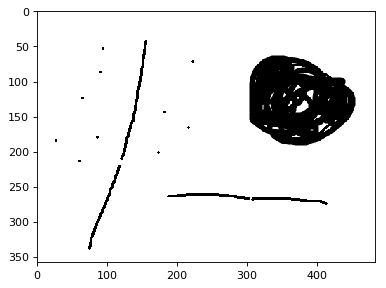

In [2]:
# Let us load an binary image. The symble of Ying-Yang should be binary (0 for black, 255 for white)
img = sitk.ReadImage('..\\data\\images\\binary_scribble.png')

myshow(img)

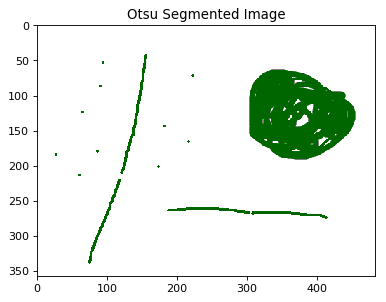

126.0


In [3]:
# It is obviously bimodal, so Otsu's method should separate black from white easily
#
otsu_filter = sitk.OtsuThresholdImageFilter()
inside_value = 1
outside_value = 0
otsu_filter.SetInsideValue(inside_value)
otsu_filter.SetOutsideValue(outside_value)
seg = otsu_filter.Execute(img)
myshow(sitk.LabelOverlay(img, seg), title='Otsu Segmented Image') # the image may be too large to use myshow
print( otsu_filter.GetThreshold())

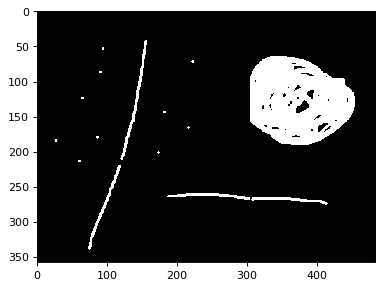

In [4]:
# create a binary (0 or 1) image
img_bw = img < otsu_filter.GetThreshold()
myshow(img_bw) # looks the same, doesn't it?

### Morphological operation

Morphological image processing is a collection of non-linear operations related to the *shape* or *morphology* of features in an image. The core idea is to *probe* an image with a simple, pre-defined shape, and then draw conclusion on how this shape fits or misses the shape in the image.  Similar to convolution of an image, these *probe* is called kernel (or **structuring element**), and itself is a binary image:

#### Structuring Element

A small binary image, i.e. a small matrix of pixels, each with a value of zero ($0$) or one ($1$)
* zero-values of the SE are ignored
* **Size** of the SE: the matrix dimensions
* **Shape** of the SE: pattern of ones and zeros
* **Origin** of the SE:: usually, one of its pixels

When an SE is placed in a binary image, each its pixel is associated with the pixel oof the area under the SE:
* The SE **fits** the image if **for each** of its pixel set to $1$ the corresponding image pixel is also $1$
* the SE **hits** (intersects) the image if **at least for one** of its pixels set to $1$ the corresponding image pixel is also $1$


<img src="SE_fit_hit.png" width="800"/> 

#### Structuring Elements in SimpleITK

SimpleITK supports 4 Structuring elements:
* sitkAnnulus, a ring
* sitkBall, 
* sitkBox
* sitkCross

Each of which you can set the *kernel Radius*

### Dilation
Let us look into morphological dilation first. The basic effect of a dilation operator on a binary image is to gradually enlarge the bondaries of regions of foreground pixels. Thus areas of foreground pixels grown in size while *holes within those regions becomes smaller*.

#### How it works

Dilation of an image $I$ by a structuring element $SE$ $s$ produces a new binary image $J$ such that

* Dilated image $J$ has ones in all locations $(x,y)$ of an origin of the SE $s$ at which $s$ **hits** the input image $I$

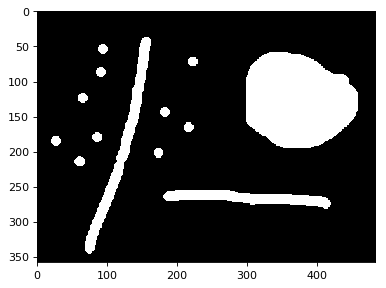

In [5]:
dilateFilter = sitk.BinaryDilateImageFilter()
dilateFilter.SetKernelType( sitk.sitkBall )
dilateFilter.SetKernelRadius( [5,5])
img_dilated = dilateFilter.Execute(img_bw)
myshow( img_dilated )

### Erosion

Erosion is the *dual* of dilation. The basic effect of an erotion operator on a binary image is to gradually sharpen the boundaries of regions of foreground pixels. Thus areas of foreground pixels shrink in size.  As a result, isolated **islands** of foreground pixels will disappear.

#### How it works

Erosion of an image $I$ by a structuring element $SE$ $s$ produces a new binary image $J$ such that

* Erodded image $J$ has ones in all locations $(x,y)$ of an origin of the SE $s$ at which $s$ **fits** the input image $I$

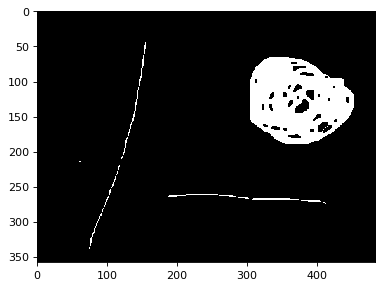

In [6]:
erodeFilter = sitk.BinaryErodeImageFilter()
erodeFilter.SetKernelType ( sitk.sitkBall )
erodeFilter.SetKernelRadius( [1,1])
img_eroded = erodeFilter.Execute( img_bw )
myshow( img_eroded )

### duality Between Dilation and Erosion

Dilation and erosion are **dual operations* in that they have opposite effects:
    
If a binary image is considered as a collection of connected regions of $1$ on backgrounds of $0$s:
* **Erosion** is the fitting of the SE to these regions
* **Dilation** the fitting of the SE (rotated if necessary) into the background, followed by inversion of the result.

### Opening

Opening of an image by a structuring element is an **erosion** followed by a **dilation**. It is useful in removing noise

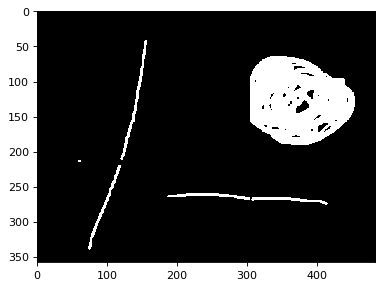

In [7]:
openingFilter = sitk.BinaryOpeningByReconstructionImageFilter()

openingFilter.SetKernelType ( sitk.sitkBall )
openingFilter.SetKernelRadius( [1,1])
img_opened = openingFilter.Execute( img_bw )
myshow( img_opened )

### Closing

Closing of an image by a structuring element is a **dilation** followed by **erosion**. It is useful to remove small (i.e. smaller than the structuring element) holes in the image.

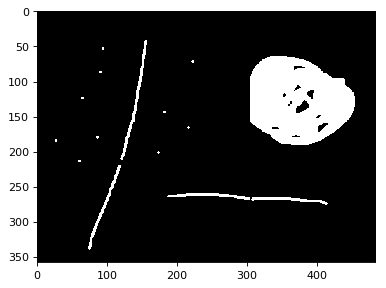

In [8]:
closingFilter = sitk.BinaryClosingByReconstructionImageFilter()

closingFilter.SetKernelType ( sitk.sitkBall )
closingFilter.SetKernelRadius( [1,1])
img_closed = closingFilter.Execute( img_bw )
myshow( img_closed )